## Tweet Classification using Logistic Regression

### Setting up data set paths

In [108]:
TRAIN_SET_PATH = "./vaccine_train_set.csv"
VALIDATION_SET_PATH = "./vaccine_validation_set.csv"

### Necessary Imports

In [109]:
import math
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.metrics import f1_score, recall_score, precision_score, ConfusionMatrixDisplay

### Reading data sets & checking whether all samples are valid

In [110]:
trainDF = pd.read_csv(TRAIN_SET_PATH)
trainDF.isnull().sum()

Unnamed: 0    0
tweet         0
label         0
dtype: int64

In [111]:
validDF = pd.read_csv(VALIDATION_SET_PATH)
validDF.isnull().sum()

Unnamed: 0    0
tweet         0
label         0
dtype: int64

### Trimming the created data frames and extracting only the required data

In [112]:
features = trainDF.drop(['label', 'Unnamed: 0'], axis=1)
X_train = [ar[0] for ar in features.values]
trainLabels = trainDF['label'].values

features = validDF.drop(['label', 'Unnamed: 0'], axis=1)
X_valid = [ar[0] for ar in features.values]
validLabels = validDF['label'].values

### Optional Preprocessor to be used during data vectorization
- Converts the given `str` to lowercase
- Ignores `@` mentions
- Ignores URL's starting with `http://` or `https://`
- Ignores any numbers or "words" which contain digits

In [113]:
def customPreprocessor(text: str):
    import re
    
    # remove url's
    trimmedText = re.sub(r'https?://\S+|www\.\S+', '', text).lower()

    # remove @ mentions and numbers
    res = list()
    wait_whitespace = False
    for c in trimmedText:
        if wait_whitespace:
            if c == " ":
                wait_whitespace = False
            continue
        elif re.match("[0-9]", c) or c == "@":
            wait_whitespace = True
            continue            
        res.append(c)
    
    return ''.join(res)

### Training & Predicting to create the learning curve
- We use a specific batch from the training set each time to train the classifier and
we make predictions on this batch as well as the validation set.
- The initial batch contains the first `len(trainSamples)*startingPct` training samples.
We use `numBatches` batches, up to 100% of the training set,
increasing the size (almost) equally in each iteration.

In [114]:
def learningCurvePredictions(classifier, trainSamples, trainLabels, validSamples, startingPct, numBatches):
    validPredictions: "list[list[int]]" = []
    trainPredictions: "list[list[int]]" = []
    trainSizes = [ math.floor(f*len(trainLabels)) for f in np.linspace(startingPct, 1, numBatches) ]
    print("Training using train set with size:")
    for i in trainSizes:
        print('\r', i, end='')
        currentBatch = trainSamples[:i]
        classifier.fit(currentBatch, trainLabels[:i])
        trainPredictions.append(classifier.predict(currentBatch))
        validPredictions.append(classifier.predict(validSamples))
    
    return trainSizes, trainPredictions, validPredictions

### Calculating metric scores for the learning curve
- For each different training set size, we calculate the **F1**, **Precision** and **Recall** scores
of the predictions made by the classifier on the corresponding training set batch and the validation set after training with that size.
- We store these scores in two `dict` objects which we return.

In [115]:
F1_KEY = "F1"
PREC_KEY = "Precision"
REC_KEY = "Recall"

def metricScores(trainPredictions: "list[list[int]]", validPredictions: "list[list[int]]", trainLabels: "list[int]", validLabels: "list[int]"):
    tScores = {
        F1_KEY: [],
        PREC_KEY: [],
        REC_KEY: []
    }
    vScores = {
        F1_KEY: [],
        PREC_KEY: [],
        REC_KEY: []
    }
    for tp, vp in zip(trainPredictions, validPredictions):
        x = len(tp)
        tScores["F1"].append(round(f1_score(trainLabels[:x], tp, average="micro"), 4))
        tScores["Precision"].append(round(precision_score(trainLabels[:x], tp, average="macro"), 4))
        tScores["Recall"].append(round(recall_score(trainLabels[:x], tp, average="macro"), 4))

        vScores["F1"].append(round(f1_score(validLabels, vp, average="micro"), 4))
        vScores["Precision"].append(round(precision_score(validLabels, vp, average="macro"), 4))
        vScores["Recall"].append(round(recall_score(validLabels, vp, average="macro"), 4))
    
    return tScores, vScores

### Plotting the learning curve(s)
If `showExtra`, we plot 2 more "learning curves" using the Precision & Recall scores as `y` values,
otherwise we plot the F1 learning curve only.

In [116]:
def plotScoreGraphs(trainSizes: "list[int]", tScores: "dict[str, list]", vScores: "dict[str, list]", showExtra: bool=False):

    def createMetricGraph(axes: plt.Axes, metric: str, trainSizes: "list[int]", tScores: "dict[str, list]", vScores: "dict[str, list]"):
        axes.grid()
        axes.set_title(f'{metric} Scoring')
        axes.plot(trainSizes, tScores[metric], "-", color="r", label="Training Set score")
        axes.plot(trainSizes, vScores[metric], "-", color="g", label="Validation Set score")    
        axes.set_xlim((trainSizes[0], trainSizes[-1]))
        axes.legend(loc="best")

    if showExtra:
        _, axes = plt.subplots(1, 3, figsize=(20, 5))
        for i, metric in enumerate(tScores.keys()):
            createMetricGraph(axes[i], metric, trainSizes, tScores, vScores)
    else:
        _, axes = plt.subplots(1, 1, figsize=(7, 5))
        createMetricGraph(axes, F1_KEY, trainSizes, tScores, vScores)
    plt.show()

### Getting the final scores in a data frame
We place the scores of the predictions made after training with 100% of
the training set in a data frame for better readability.

In [117]:
def metricStatsDF(tScores: "dict[str, list]", vScores: "dict[str, list]"):
    metricStats: "dict[str, list]" = {}
    for metric in tScores.keys():
        metricStats[metric] = [tScores[metric][-1], vScores[metric][-1]]
    
    return pd.DataFrame(metricStats, index=['Train', 'Validation'])


### Displaying the confusion matrix
We can change the displayed labels (`0` -> `Neutral`, `1` -> `Anti-Vaccine`, `2` -> `Pro-Vaccine`) if desired.

In [118]:
def displayConfusionMatrix(trueLabels, predictions, title: str, displayLabels=None):
    disp = ConfusionMatrixDisplay.from_predictions(trueLabels, predictions[-1], cmap=plt.cm.Reds)
    if displayLabels is not None:
        disp.ax_.set_xticklabels(displayLabels)
        disp.ax_.set_yticklabels(displayLabels)
    plt.xlabel('Classifier predicted labels', fontsize=11)
    plt.ylabel('True labels', fontsize=11)
    plt.title(title, fontsize=14)
    plt.show()

### Execution flow

In [119]:
# Data vectorization with the desired parameters
vectorizer = TfidfVectorizer(max_df=0.85, min_df=0.01, ngram_range=(1,3))
# vectorizer = TfidfVectorizer(preprocessor=customPreprocessor, stop_words="english", max_df=0.85, min_df=0.01)

# We create the vocabulary out of the *training* set only, and vectorize the training set samples accodringly
trainSamples = vectorizer.fit_transform(X_train)
# We vectorize the validation set samples using the existing vocabulary (for better generalization)
validSamples = vectorizer.transform(X_valid)

# Classifier initialization with the desired parameters
lrClassifier = LogisticRegression(max_iter=1000, multi_class="multinomial")
# Making learning curve predictions
trainSizes, trainPredictions, validPredictions = learningCurvePredictions(lrClassifier, trainSamples, trainLabels, validSamples, 
                                                                          startingPct=0.025, numBatches=15)
# Calculating metric scores
tScores, vScores = metricScores(trainPredictions, validPredictions, trainLabels, validLabels)

Training using train set with size:
 15976

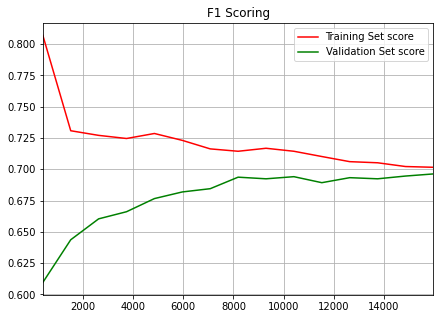

In [120]:
plotScoreGraphs(trainSizes, tScores, vScores, False)

In [121]:
metricStatsDF(tScores, vScores)

,F1,Precision,Recall
Train,0.7016,0.6536,0.5973
Validation,0.6963,0.6436,0.5883


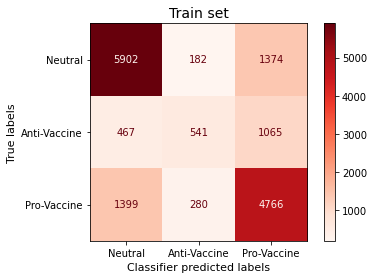

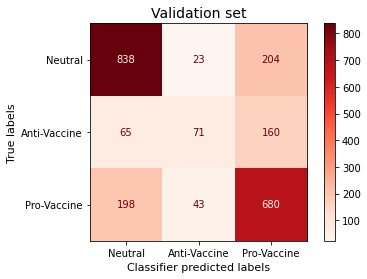

In [122]:
labels = ['Neutral', 'Anti-Vaccine', 'Pro-Vaccine']
displayConfusionMatrix(trainLabels, trainPredictions, title='Train set', displayLabels=labels)
displayConfusionMatrix(validLabels, validPredictions, title='Validation set', displayLabels=labels)